In [1]:
import requests
import json
import geopandas as gpd
from io import StringIO
import folium
from pyproj import Transformer

# Experminetal Setup for trees details

In [42]:
import math

# Calculate the bounding box of the tile
def tile_to_bbox(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_min = xtile / n * 360.0 - 180.0
    lat_min_rad = math.atan(math.sinh(math.pi * (1 - 2 * (ytile + 1) / n)))
    lat_min = math.degrees(lat_min_rad)
    lon_max = (xtile + 1) / n * 360.0 - 180.0
    lat_max_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_max = math.degrees(lat_max_rad)
    # coords is a list of tuples that are also a list with first lat and then lon
    # should contain 4 elements - corners of the bounding box
    coords = [
        [lat_max, lon_min],  # top-left
        [lat_max, lon_max],  # top-right
        [lat_min, lon_max],  # bottom-right
        [lat_min, lon_min],  # bottom-left
    ]
    return coords
 

# Example usage
x, y,z = 143478, 87626, 18
corners = tile_to_bbox(x, y, z)

corners


[[51.11559271064121, 17.03704833984375],
 [51.11559271064121, 17.038421630859375],
 [51.11473061746101, 17.038421630859375],
 [51.11473061746101, 17.03704833984375]]

In [43]:
# Define the transformer from EPSG:4326 to EPSG:3857
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

def transform_coordinates(x, y):
    return transformer.transform(x, y)

corners_transformed = []
for corner in corners:
    lat, lon = corner
    x, y = transform_coordinates(lon, lat)
    corners_transformed.append([x, y])

corners_transformed

[[1896555.545811793, 6641766.261755536],
 [1896708.4198683635, 6641766.261755536],
 [1896708.4198683635, 6641613.387698963],
 [1896555.545811793, 6641613.387698963]]

In [44]:
url = "https://aplikacja.mapadrzew.com/kmd/features/inGeometry"

# Define the payload for the POST request
payload = {
    "orderID": "1218202460400rnSt0y",
    "prem": None,
    "provines": ["dolnoslaskie"],
    "coords": corners_transformed,
    "epsg": 3857,
    "type": "polygon",
}

# Make the POST request
response = requests.post(url, json=payload)
data = response.json()
transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)


def transform_coordinates(x, y):
    return transformer.transform(x, y)


trees = []
for item in data["data"]:
    x = float(item["X"])
    y = float(item["Y"])
    lon, lat = transform_coordinates(x, y)
    tree = {
        "height": item["a"],
        "e": item["e"],
        "volume": item["f"],
        "area": item["g"],
        "latitude": lat,
        "longitude": lon,
    }
    trees.append(tree)

if trees:
    avg_lat = sum(tree["latitude"] for tree in trees) / len(trees)
    avg_lon = sum(tree["longitude"] for tree in trees) / len(trees)
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=17)

    # Add markers for each tree
    for tree in trees:
        folium.Marker(
            location=[tree["latitude"], tree["longitude"]],
            popup=f"height: {tree['height']}, e: {tree['e']}, volume: {tree['volume']}, area: {tree['area']}",
        ).add_to(m)

    # add a ploygon of corners of the tile
    folium.Polygon(corners, color="blue", fill=True, fill_color="red", fill_opacity=0.2).add_to(m)
else:
    print("No trees to display.")

m

In [62]:
import folium

# Create a map centered at a specific location
m = folium.Map(location=[51.1079, 17.0385], zoom_start=12)

# Add WMTS layer to the map
folium.raster_layers.WmsTileLayer(
    url='https://gis1.um.wroc.pl/arcgis/services/ogc/OGC_ortofoto_2024/MapServer/WMSServer',
    name='WMTS Layer',
    layers='1',
    fmt='image/png',
    transparent=True,
    version='1.1.0',
    tiled=True,
    attr='&copy; Wrocław GIS'
).add_to(m)

# Add layer control to toggle the WMS layer
folium.LayerControl().add_to(m)

# Display the map
m

In [68]:
import requests
from PIL import Image
from io import BytesIO

# Define the WMS service URL and parameters
wmts_url = 'https://gis1.um.wroc.pl/arcgis/services/ogc/OGC_ortofoto_2024/MapServer/WMSServer'
params = {
    "SERVICE": "WMS",
    "VERSION": "1.1.0",
    "REQUEST": "GetMap",
    "FORMAT": "image/png",
    "TRANSPARENT": "true",
    "LAYERS": "1",
    "TILED": "true",
    "WIDTH": "2048",
    "HEIGHT": "2048",
    "SRS": "CRS:84",
    "STYLES": "",
    "BBOX": "17.03704833984375,51.11559271064121,17.038421630859375,51.116454787737155",
}

# Fetch the tile image
response = requests.get(wmts_url, params=params)
response.raise_for_status()  # Check if the request was successful

# Save the image as a PNG file
image = Image.open(BytesIO(response.content))
image.save('tile.png')

print("Tile saved as 'tile.png'")

Tile saved as 'tile.png'


# Prepare Functions for the Dataset Pipeline

In [61]:
from matplotlib.pylab import f
import requests
from PIL import Image
from io import BytesIO
import time
# Get a tile as an inmage and save it to bytes in a dataset torch

def prepare_tile_image(bbox, resolution=1024, crs='CRS:84'):
    # Define the WMS service URL and parameters
    wmts_url = 'https://gis1.um.wroc.pl/arcgis/services/ogc/OGC_ortofoto_2024/MapServer/WMSServer'
    params = {
        "SERVICE": "WMS",
        "VERSION": "1.1.0",
        "REQUEST": "GetMap",
        "FORMAT": "image/png",
        "TRANSPARENT": "true",
        "LAYERS": "1",
        "TILED": "true",
        "WIDTH": f"{resolution}",
        "HEIGHT": f"{resolution}",
        "SRS": crs,
        "STYLES": "",
        "BBOX": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
    }

    for _ in range(5):  # Try up to 5 times
        response = requests.get(wmts_url, params=params)
        if response.status_code == 200:
            break
        else:
            print(f"Attempt failed with status code {response.status_code}. Retrying...")
            time.sleep(2)  # Wait for 2 seconds before retrying
    response.raise_for_status()  # Check if the request was successful

    image_bytes = BytesIO(response.content)
    image = Image.open(image_bytes)

    #return a tuple of image and metadata about the tile.
    metadata = {
        "bbox": bbox,
        "resolution": resolution,
        "crs": crs,
    }
    return image, metadata

In [20]:
import math

def tile_to_bbox(xtile, ytile, zoom):
    n = 2.0**zoom
    lon_min = xtile / n * 360.0 - 180.0
    lat_min_rad = math.atan(math.sinh(math.pi * (1 - 2 * (ytile + 1) / n)))
    lat_min = math.degrees(lat_min_rad)
    lon_max = (xtile + 1) / n * 360.0 - 180.0
    lat_max_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_max = math.degrees(lat_max_rad)
    # Return the bounding box as a list of [min_lon, min_lat, max_lon, max_lat]
    return [lon_min, lat_min, lon_max, lat_max]


In [62]:
from pyproj import Transformer

def get_corners_from_bbox(bbox):
    x1, y1, x2, y2 = bbox
    corners = [
        [x1, y1],  # top-left
        [x2, y1],  # top-right
        [x2, y2],  # bottom-right
        [x1, y2],  # bottom-left
    ]
    return corners

def get_trees_details(corners):
    url = "https://aplikacja.mapadrzew.com/kmd/features/inGeometry"

    trees = []
    # coords payload should be in epsg:3857
    payload = {
        "orderID": "142025418297RvPru",
        "prem": None,
        "provines": ["dolnoslaskie"],
        "coords": corners,
        "epsg": 4326,
        "type": "polygon",
    }
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    response = requests.post(url, json=payload)
    data = response.json()
    if not data["data"]:
        # print("No trees found in the tile.")
        return trees
    for item in data["data"]:
        x = float(item["X"])
        y = float(item["Y"])
        lon, lat = transformer.transform(x, y)
        tree = {
            "height": item["a"],
            "e": item["e"],
            "volume": item["f"],
            "area": item["g"],
            "latitude": lat,
            "longitude": lon,
        }
        trees.append(tree)

    return trees

In [22]:
def get_tile_coordinates_from_lat_long(lat, long, zoom):
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom
    xtile = int((long + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return xtile, ytile

In [23]:
import numpy as np

def area_to_radius(area_meters, tile_edge_pixels=1024, tile_edge_meters=96):
    # Calculate the radius in meters
    radius_meters = (area_meters / np.pi) ** 0.5

    # Calculate the scale factor (pixels per meter)
    scale_factor = tile_edge_pixels / tile_edge_meters

    # Convert the radius to pixels
    radius_pixels = int(radius_meters * scale_factor)

    return radius_pixels

In [25]:
def geo_to_pixel(lat, lon, bbox, tile_size):
    min_lon, min_lat, max_lon, max_lat = bbox
    x = (lon - min_lon) / (max_lon - min_lon) * tile_size[0]
    y = (max_lat - lat) / (max_lat - min_lat) * tile_size[1]
    return int(x), int(y)

# Examle usage:

In [8]:
x_tile, y_tile = get_tile_coordinates_from_lat_long(
    51.153502274010194, 16.90120694577385, 18
)
x_tile, y_tile

(143379, 87582)

In [13]:
x_tile, y_tile = get_tile_coordinates_from_lat_long(
    51.06355157265516, 17.12361013706642, 18
)
x_tile, y_tile

(143541, 87686)

In [53]:
# tile_coords = (143479, 87626, 18)


In [14]:
tile_coords = (x_tile, y_tile, 18)

In [15]:
bbox = tile_to_bbox(*tile_coords)

In [16]:
corners = get_corners_from_bbox(bbox)
corners

[[17.123565673828125, 51.062975588514966],
 [17.12493896484375, 51.062975588514966],
 [17.12493896484375, 51.063838646941576],
 [17.123565673828125, 51.063838646941576]]

## Show corners on a folium map

In [17]:
import folium
avg_lat = sum(corner[1] for corner in corners) / len(corners)
avg_lon = sum(corner[0] for corner in corners) / len(corners)
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=18)

for corner in corners:
    folium.Marker(
        location=[corner[1], corner[0]],
        popup=f"Lat: {corner[1]}, Lon: {corner[0]}",
    ).add_to(m)

folium.Polygon(locations=[[corner[1], corner[0]] for corner in corners], color="blue", fill=True, fill_color="red", fill_opacity=0.2).add_to(m)

m

## Get trees details from corners

In [57]:
trees = get_trees_details(corners)
trees

[{'height': 22.46,
  'e': 3.23,
  'volume': 427.89,
  'area': 33,
  'latitude': 51.1151040937641,
  'longitude': 17.039693108393344},
 {'height': 22.2,
  'e': 3.89,
  'volume': 203.42,
  'area': 16,
  'latitude': 51.11508771006279,
  'longitude': 17.039740252877767},
 {'height': 22.02,
  'e': 2.51,
  'volume': 582.79,
  'area': 36,
  'latitude': 51.115081029810355,
  'longitude': 17.03959522706167},
 {'height': 22.08,
  'e': 1.91,
  'volume': 789.9,
  'area': 42,
  'latitude': 51.11504941561254,
  'longitude': 17.039628043417313},
 {'height': 21.98,
  'e': 4.48,
  'volume': 397.64,
  'area': 22,
  'latitude': 51.11504314250858,
  'longitude': 17.039740515185834},
 {'height': 9.85,
  'e': 0.67,
  'volume': 163.03,
  'area': 20,
  'latitude': 51.11501153336018,
  'longitude': 17.03956982180712},
 {'height': 22.34,
  'e': 3.61,
  'volume': 620.69,
  'area': 43,
  'latitude': 51.11501367853322,
  'longitude': 17.039679650732072},
 {'height': 23.24,
  'e': 3.5,
  'volume': 854.16,
  'area':

## Show trees details on folium map

In [58]:
import folium
avg_lat = sum(tree["latitude"] for tree in trees) / len(trees)
avg_lon = sum(tree["longitude"] for tree in trees) / len(trees)
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=18)

for tree in trees:
    folium.Marker(
        location=[tree["latitude"], tree["longitude"]],
        popup=f"height: {tree['height']}, e: {tree['e']}, volume: {tree['volume']}, area: {tree['area']}",
    ).add_to(m)

m

## Display tile image

In [59]:

tile, tile_metadata = prepare_tile_image(bbox, resolution=1024)


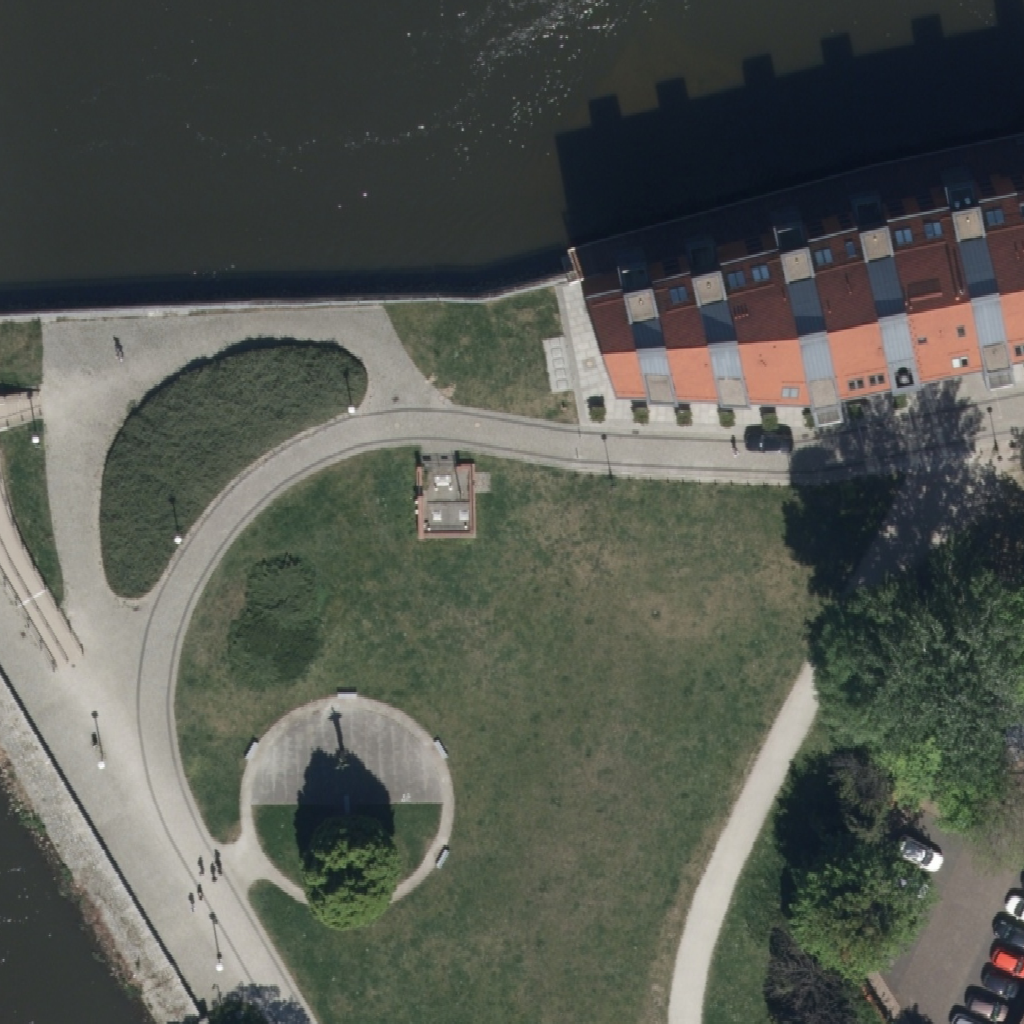

In [60]:
tile

# Main dataset pipeline loop

In [64]:
from operator import le
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

images_dir = os.path.join("data", "images")
metadata_dir = os.path.join("data", "metadata")
result_dir = os.path.join("data", "results")
os.makedirs(images_dir, exist_ok=True)
os.makedirs(metadata_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)
# (143379, 87582)
# (143541, 87686)
zoom = 18
tile_resolution = 1024
starting_tile = (143424, 87582, zoom)
ending_tile = (143541, 87686, zoom)

total_tiles = (ending_tile[0] - starting_tile[0]) * (ending_tile[1] - starting_tile[1])

for x_tile in tqdm(range(starting_tile[0], ending_tile[0]), desc="Processing X Tiles"):
    for y_tile in tqdm(
        range(starting_tile[1], ending_tile[1]), desc=f"Processing Y Tiles", leave=False
    ):
        tile_coords = (x_tile, y_tile, zoom)
        # print(f"Processing tile {tile_coords}...")
        bbox = tile_to_bbox(*tile_coords)
        corners = get_corners_from_bbox(bbox)
        trees = get_trees_details(corners)
        tile, tile_metadata = prepare_tile_image(bbox, resolution=tile_resolution)
        tile_metadata["edge_in_meters"] = 96

        tile_name = f"tile_{x_tile}_{y_tile}"
        tile_image_path = os.path.join(images_dir, f"{tile_name}.jpg")
        tile.convert("RGB").save(tile_image_path)

        transformed_trees = []
        tile_size = (tile_resolution, tile_resolution)
        image = np.array(tile)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for tree in trees:
            lat = tree["latitude"]
            lon = tree["longitude"]
            x, y = geo_to_pixel(lat, lon, bbox, tile_size)
            radius = area_to_radius(tree["area"])
            tree_transformed = {
                "latitude": lat,
                "longitude": lon,
                "x": x,
                "y": y,
                "radius": radius,
            }
            transformed_trees.append(tree_transformed)
            cv2.circle(image_rgb, (x, y), radius=2, color=(255, 0, 255), thickness=2)
            cv2.circle(
                image_rgb,
                (x, y),
                radius=radius,
                color=(0, 255, 0),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

        metadata_path = os.path.join(metadata_dir, f"{tile_name}.json")
        tile_metadata = {
            "tile_coords": tile_coords,
            "tile_metadata": tile_metadata,
            "corners": corners,
            "trees": trees,
            "transformed_trees": transformed_trees,
        }

        with open(metadata_path, "w") as file:
            json.dump(tile_metadata, file, indent=4)

        result_path = os.path.join(result_dir, f"result_{tile_name}.jpg")
        cv2.imwrite(result_path, image_rgb)

        # plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
        # plt.show()

Processing X Tiles:  54%|█████▍    | 63/117 [5:12:21<4:37:29, 308.33s/it]

Attempt failed with status code 502. Retrying...


Processing X Tiles:  77%|███████▋  | 90/117 [7:28:13<2:15:34, 301.29s/it]

Attempt failed with status code 502. Retrying...


Processing X Tiles: 100%|██████████| 117/117 [9:42:39<00:00, 298.80s/it]  


# Save dataset to disk

In [69]:
from importlib import metadata
from datasets import Dataset, DatasetDict

def load_dataset(images_dir, metadata_dir, result_dir):
    images, metadata, results = [], [], []
    for filename in os.listdir(images_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(images_dir, filename)
            json_path = os.path.join(metadata_dir, f"{filename[:-4]}.json")
            result_path = os.path.join(result_dir, f"result_{filename}")

            with Image.open(image_path) as img:
                images.append(img)

            with open(json_path, "r") as file:
                metadata.append(json.load(file))
            
            with Image.open(result_path) as img:
                results.append(img)
            
    return Dataset.from_dict({
        "images": images,
        "metadata": metadata,
        "results": results,
    })


In [70]:
dataset = load_dataset(images_dir, metadata_dir, result_dir)
dataset.save_to_disk("dataset/trees_dataset")

Saving the dataset (19/19 shards): 100%|██████████| 16880/16880 [00:16<00:00, 1021.61 examples/s]


# Push dataset to the huggingface dataset hub

In [71]:
dataset.push_to_hub("Filipstrozik/satellite_trees_wroclaw_2024")

Uploading the dataset shards: 100%|██████████| 19/19 [10:57<00:00, 34.60s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Filipstrozik/satellite_trees_wroclaw_2024/commit/3896f4d475743ecdda12a7284e54e5e4fea08a79', commit_message='Upload dataset', commit_description='', oid='3896f4d475743ecdda12a7284e54e5e4fea08a79', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Filipstrozik/satellite_trees_wroclaw_2024', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Filipstrozik/satellite_trees_wroclaw_2024'), pr_revision=None, pr_num=None)